In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statsmodels==0.11.1
!pip install fbprophet==0.7.1

In [3]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_path = '/content/drive/MyDrive/dacon'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [5]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [6]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [7]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7661, 1380, 10)
train_y_array (7661, 120, 10)
test_x_array (535, 1380, 10)



In [8]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [9]:
data_col_idx = 1 # 1 open, 2 high

In [10]:
import datetime
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

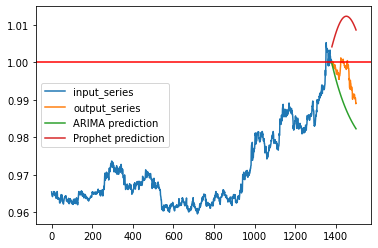

In [37]:
idx = 1121
x_series = train_x_array[idx,:,data_col_idx]
y_series = train_y_array[idx,:,data_col_idx]

model = ARIMA(x_series, order=(3,0,1))
fit  = model.fit()
preds1 = fit.predict(1381,1380+120, typ='levels')

x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=False,
                  weekly_seasonality=False, daily_seasonality=True,
                  changepoint_prior_scale=0.06)
prophet.fit(x_df)

future_data = prophet.make_future_dataframe(periods=120, freq='min')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

pred_y = forecast_data.yhat.values[-120:]

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds1, label = 'ARIMA prediction')
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'Prophet prediction')
plt.legend()
plt.show()

In [39]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)

    # 105% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.041) * 1

    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [13]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index

In [14]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,data_col_idx]
        fit = None
        try:
          model = ARIMA(x_series, order=(3,0,1))
          fit  = model.fit()
        except Exception as e:
          model = ARIMA(x_series, order=(4,0,1))
          fit  = model.fit()
          
        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()
        prophet = Prophet(seasonality_mode='multiplicative', 
                          yearly_seasonality=False,
                          weekly_seasonality=False, daily_seasonality=True,
                          changepoint_prior_scale=0.06)
        prophet.fit(x_df)

        preds = fit.predict(1381,1380+120, typ='levels')

        future_data = prophet.make_future_dataframe(periods=120, freq='min')
        forecast_data = prophet.predict(future_data)
        forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        max_two_model = np.maximum(pred_y, preds)

        test_pred_array[idx,:] = max_two_model
    except Exception as e:
        print(repr(e))
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 535/535 [52:52<00:00,  5.93s/it]


In [43]:
submission = array_to_submission(test_x_array, test_pred_array)
submission['sample_id'] = submission['sample_id'] + 7661

In [44]:
submission.buy_quantity.value_counts() 

0    314
1    221
Name: buy_quantity, dtype: int64

In [45]:
submission.to_csv(data_path+"/submission.csv", index = False)